In [1]:
from astropy import constants as const
from scipy.stats import stats
import scipy.integrate as integrate
from scipy.stats import norm
from scipy import interpolate
from astropy.io import fits
from PIL import Image
from astropy.table import Table
from astropy import units as u
from iminuit import Minuit
from scipy.optimize import curve_fit
from iminuit.cost import LeastSquares
import numpy as np
import pysynphot as S
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize'] = 'xx-large'
plt.rcParams['ytick.labelsize'] = 'xx-large'

In [2]:
NBBANDS = 6
band_to_number = {'u':0,'g':1,'r':2,'i':3,'z':4,'y4':5}
band_to_number_2 = {'u':0,'g':1,'r':2,'i':3,'z':4,'y':5}
number_to_band = {0:'u',1:'g',2:'r',3:'i',4:'z',5:'y4'}
number_to_band_2 = {0:'u',1:'g',2:'r',3:'i',4:'z',5:'y'}
filtercolor = ['blue','green','red','orange','grey','black']
NBCOLORS=NBBANDS-1
number_to_color = {0:'U-G',1:'G-R',2:'R-I',3:'I-Z',4:'Z-Y'}
color_to_number = {'U-G':0,'G-R':1,'R-I':2,'I-Z':3,'Z-Y':4}
mpl_colors_col = ['b','g','r','y','k']

WLMIN = 3000. # Minimum wavelength : PySynPhot works with Angstrom
WLMAX = 11000. # Minimum wavelength : PySynPhot works with Angstrom

NBINS = int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
BinWidth = (WLMAX-WLMIN)/float(NBINS) # Bin width in Angstrom
WL = np.linspace(WLMIN,WLMAX,NBINS)   # Array of wavelength in Angstrom

# LSST collectif surface
Deff = 642.3 # effective radius in cm
Seff = np.pi*Deff**2/4  # in cm2
S.refs.setref(area = Seff, waveset=None) # set by default to 6.4230 m2
S.refs.set_default_waveset(minwave = WLMIN, maxwave = WLMAX, num = NBINS, delta = BinWidth, log = False)
S.refs.showref()

EXPOSURE = 30.0
sig_inst = 10
pixScale = 0.2

pysynphot_root_path = os.environ['PYSYN_CDBS']
path_sed_calspec = os.path.join(pysynphot_root_path,'calspec')

flatsp = S.FlatSpectrum(20, fluxunits='abmag')
flatsp_norm = flatsp.renorm(20, 'abmag', S.ObsBandpass('johnson,v'))

nbr_filters = 7

graphtable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\4cm1612bm_tmg.fits
 comptable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\5182153pm_tmc.fits
thermtable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\3241637sm_tmt.fits
      area: 324015.4546769212
   waveset: Min: 3000.0, Max: 11000.0, Num: None, Delta: 1.0, Log: False


In [3]:
t = Table.read('table_summary_selectedcalspec.fits')
t

OBJNAME,RA,DEC,SP_TYPE,SP_QUAL,magU,magB,magV,magR,magI,FILES,calcU,calcB,calcV,calcR,calcI,factor,VmI
bytes10,float64,float64,bytes12,bytes1,float64,float64,float64,float64,float64,bytes30,float64,float64,float64,float64,float64,float64,float64
NGC7293,337.411,-20.837,DAO.5,C,11.894,13.158,13.524,13.689,13.898,ngc7293_005.fits,11.917,13.180,13.538,13.734,14.234,26.01,-0.697
G93-48,328.106,2.389,DA2.8,C,11.942,12.732,12.743,12.839,12.938,g93_48_004.fits,11.982,12.717,12.728,12.836,13.234,12.34,-0.506
HZ4,58.842,9.788,DA3.4,C,13.917,14.592,14.506,14.580,14.642,hz4_stis_007.fits,13.923,14.587,14.472,14.561,14.718,61.484,-0.246
HD172167,279.235,38.784,A0Va,C,0.030,0.030,0.030,0.070,0.100,alpha_lyr_stis_010.fits,0.000,0.000,0.000,0.000,0.000,0.0001,0.000
HD163466,268.106,60.396,A2,E,100000000000000000000.000,7.040,6.850,100000000000000000000.000,100000000000000000000.000,hd163466_stis_005.fits,7.143,7.023,6.831,6.685,6.582,0.05399,0.249
HD101452,175.057,-39.147,A2/3(m)A8-F2,E,100000000000000000000.000,7.840,8.200,100000000000000000000.000,100000000000000000000.000,hd101452_stis_002.fits,7.898,7.809,7.508,7.289,7.142,0.10073,0.366
HD106252,183.373,10.042,G0,E,100000000000000000000.000,8.000,100000000000000000000.000,7.000,100000000000000000000.000,hd106252_stis_005.fits,8.101,8.007,7.394,6.948,6.646,0.090687,0.748
FLAT,0.000,0.000,flat,0,9.721,10.369,10.000,9.501,9.001,flat,9.721,10.369,10.000,9.501,9.001,1,0.999


In [4]:
sel_spectrum_idx = 0

In [5]:
if sel_spectrum_idx == 7 :
    
    Spec = flatsp_norm

else :
    
    Spec_norm = S.FileSpectrum(os.path.join(pysynphot_root_path, 'calspec', t["FILES"][sel_spectrum_idx]))
    Spec = Spec_norm.renorm(20, 'abmag', S.ObsBandpass('johnson,v'))

Spec.convert('abmag')

In [6]:
dir_cadences="D:\Projet de recherche\Stage\cadences"
all_my_cadence_files= ["cadence_lmc_baseline2018a_extr_v1.csv",
                      "cadence_lmc_baseline_2snaps_v1_extr_v1.csv",
                      "cadence_lmc_baseline_v1_extr_v1.csv",
                      "cadence_lmc_rolling_nm_scale1_extr_v1.csv",
                      "cadence_lmc_rolling_scale0_extr_v1.csv"
                     ]


dir_atmo = "D:\Projet de recherche\Stage\Atmosphere"
all_my_atmo_files = ["lmc_baseline2018a_extr_v1_atmo.csv",
                     "lmc_baseline_2snaps_v1_extr_v1_atmo.csv",
                     "lmc_baseline_v1_extr_v1_atmo.csv",
                     "lmc_rolling_nm_scale1_extr_v1_atmo.csv",
                     "lmc_rolling_scale0_extr_v1_atmo.csv"
                    ]


dir_LSST = "D:\Projet de recherche\Stage"
LSST_file = "LSST_throughput.csv"

In [7]:
sel_cadence_idx = 0

In [8]:
cadence_file=os.path.join(dir_cadences,all_my_cadence_files[sel_cadence_idx])
df = pd.read_csv(cadence_file, index_col=0)
df

,observationId,night,observationStartMJD,fiveSigmaDepth,filter,airmass,skyBrightness,seeingFwhmEff,fieldId,fieldRA,fieldDec
0,10033,13,59865.307442,22.042763,y,1.326809,17.868655,0.734701,138,72.000005,-70.933132
1,10158,13,59865.364815,21.847938,y,1.362533,17.829956,0.859026,122,88.568878,-72.896915
2,10160,13,59865.365718,21.894638,y,1.315613,17.861954,0.841153,150,81.777206,-70.757749
3,10161,13,59865.366169,21.944466,y,1.267955,17.897698,0.822736,190,84.972540,-68.155026
4,10166,13,59865.368438,21.905326,y,1.277317,17.874108,0.842751,178,76.364237,-68.470535
...,...,...,...,...,...,...,...,...,...,...,...
752,2371968,3648,63500.338715,23.347211,r,1.338508,20.171447,1.313724,138,72.000005,-70.933132
753,2372034,3648,63500.370822,23.377553,r,1.391936,20.140500,1.252691,122,88.568878,-72.896915
754,2372039,3648,63500.373102,23.480260,r,1.278194,20.210373,1.190228,178,76.364237,-68.470535
755,2372040,3648,63500.373553,23.375525,r,1.328889,20.176793,1.284311,150,81.777206,-70.757749


In [9]:
atmo_file = os.path.join(dir_atmo,all_my_atmo_files[sel_cadence_idx])
df_atmo = pd.read_csv(atmo_file, index_col=0)
df_atmo

,1,2,3,4,5,6,7,8,9,10,...,748,749,750,751,752,753,754,755,756,757
3000,0.006685,0.005863,0.006943,0.008378,0.008064,0.008187,0.006856,0.005650,0.006884,0.008172,...,0.001133,0.001360,0.000911,0.005435,0.005023,0.006416,0.005187,0.008035,0.006637,0.007782
3010,0.011053,0.009818,0.011440,0.013536,0.013081,0.013259,0.011310,0.009497,0.011351,0.013238,...,0.002240,0.002638,0.001839,0.009175,0.008555,0.010648,0.008802,0.013038,0.010981,0.012673
3020,0.016794,0.015079,0.017332,0.020177,0.019565,0.019804,0.017151,0.014633,0.017209,0.019776,...,0.003951,0.004579,0.003300,0.014185,0.013324,0.016233,0.013667,0.019508,0.016694,0.019016
3030,0.027757,0.025246,0.028544,0.032594,0.031731,0.032069,0.028279,0.024593,0.028364,0.032029,...,0.007809,0.008878,0.006663,0.023938,0.022677,0.026935,0.023179,0.031650,0.027611,0.030958
3040,0.033425,0.030548,0.034327,0.038920,0.037945,0.038327,0.034024,0.029800,0.034121,0.038282,...,0.010046,0.011342,0.008639,0.029049,0.027605,0.032483,0.028180,0.037854,0.033258,0.037072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11960,0.970875,0.970113,0.971113,0.972133,0.971932,0.972011,0.971033,0.969915,0.971059,0.972001,...,0.961002,0.961944,0.959724,0.969716,0.969333,0.970625,0.969485,0.971913,0.970830,0.971752
11970,0.970875,0.970113,0.971113,0.972133,0.971932,0.972011,0.971033,0.969915,0.971059,0.972001,...,0.961002,0.961944,0.959724,0.969716,0.969333,0.970625,0.969485,0.971913,0.970830,0.971752
11980,0.952743,0.951572,0.953109,0.954684,0.954373,0.954495,0.952986,0.951267,0.953026,0.954481,...,0.937810,0.939215,0.935917,0.950962,0.950374,0.952359,0.950608,0.954344,0.952674,0.954095
11990,0.952743,0.951572,0.953109,0.954684,0.954373,0.954495,0.952986,0.951267,0.953026,0.954481,...,0.937810,0.939215,0.935917,0.950962,0.950374,0.952359,0.950608,0.954344,0.952674,0.954095


In [10]:
df_LSST = pd.read_csv(os.path.join(dir_LSST, LSST_file), index_col=0)
df_LSST

,wl,u,g,r,i,z,y
0,300,0.000711,0.000000,0.000000,0.000034,0.000000,0.000000
1,301,0.000440,0.000000,0.000000,0.000155,0.000000,0.000000
2,302,0.000591,0.000000,0.000000,0.000072,0.000000,0.000000
3,303,0.000022,0.000000,0.000000,0.000034,0.000000,0.000000
4,304,0.000229,0.000000,0.000000,0.000034,0.000000,0.000000
...,...,...,...,...,...,...,...
896,1196,0.000029,0.000298,0.000088,0.000121,0.000560,0.016426
897,1197,0.000024,0.000357,0.000084,0.000150,0.000630,0.016413
898,1198,0.000016,0.000427,0.000080,0.000187,0.000711,0.016397
899,1199,0.000012,0.000501,0.000076,0.000235,0.000802,0.016303


In [11]:
from scipy.stats import uniform

NYEARS = 10
NDAYS = NYEARS*365.25

xmin = 0
xmax = NDAYS
N=10000 # le nombre de simulation peut être artibrairement tres grand. Ce qui compte c'est de calculer l'efficacité de detection de la courbe de lumière
list_t0 = uniform.rvs(xmin,xmax,N) + df['observationStartMJD'][0]

#plt.hist(list_t0,bins=int(NDAYS));
#plt.xlabel("$t_0$ (jours)")
#plt.title("Distribution des $t_0$")

In [12]:
N = 1000
uminmin = 0
uminmax = 2
umin = uniform.rvs(uminmin,uminmax,N)

#plt.hist(umin,bins=100)
#plt.xlabel("$u_{min}$")
#plt.ylabel("$p(u_{min})$")
#plt.title("$u_{min}$ distribution")

In [13]:
import astroquery
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
from photutils.aperture import SkyCircularAperture
from regions import CircleSkyRegion


result_table = Simbad.query_object("lmc")

galaxy_coord = SkyCoord(ra=result_table["RA"][0]+"hour",dec=result_table["DEC"][0]+ "degrees")
galaxy_ra = galaxy_coord.ra.deg
galaxy_dec = galaxy_coord.dec.deg
print(galaxy_ra,galaxy_dec)

positions = SkyCoord(galaxy_ra, galaxy_dec, unit = 'deg').galactic
aper = SkyCircularAperture(positions, 3.5/2 * u.deg)
Circle = CircleSkyRegion(positions, 3.5/2 * u.deg)

80.89416666666666 -69.75611111111111


In [14]:
def u(t):
    return np.sqrt(u0**2+ ((t-t0)/tE)**2)

In [15]:
def A(u):
    return (u**2+2)/u/np.sqrt(u**2+4)

In [16]:
def Ab(t, u0, t0, tE) :
    return ((np.sqrt(u0**2+ ((t-t0)/tE)**2))**2+2)/(np.sqrt(u0**2+ ((t-t0)/tE)**2))/np.sqrt((np.sqrt(u0**2+ ((t-t0)/tE)**2))**2+4) 

In [17]:
def Gauss(x, A, mu ,sigma) :
    return A*np.exp(-(x-mu)**2/(2*sigma**2))/sigma/np.sqrt(2*np.pi)

In [18]:
def linear(x, alpha, beta) : 
    return alpha*x + beta

In [19]:
def Model(t, u0, t0, tE, F, N) :
    return (((np.sqrt(u0**2+ ((t-t0)/tE)**2))**2+2)/(np.sqrt(u0**2+ ((t-t0)/tE)**2))/np.sqrt((np.sqrt(u0**2+ ((t-t0)/tE)**2))**2+4)) * F + N  

In [20]:
LSST = []

for index in np.arange(6) :
    
    filter_name = number_to_band_2[index]
    bp = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST[filter_name].values, name = filter_name)                      
    LSST.append(bp)

Wave = df_LSST["wl"]*10
Wavelength = np.array(Wave)

In [21]:
ObservationStartMJD_u = []
ObservationStartMJD_g = []
ObservationStartMJD_r = []
ObservationStartMJD_i = []
ObservationStartMJD_z = []
ObservationStartMJD_y = []

for i in range (len(df["observationId"])) :
    
    if (df['filter'][i] == 'u') :
            
            ObservationStartMJD_u.append(df["observationStartMJD"].values[i])
    
    if (df['filter'][i] == 'g') :
            
            ObservationStartMJD_g.append(df["observationStartMJD"].values[i])
            
    if (df['filter'][i] == 'r') :
            
            ObservationStartMJD_r.append(df["observationStartMJD"].values[i])
            
    if (df['filter'][i] == 'i') :
            
            ObservationStartMJD_i.append(df["observationStartMJD"].values[i])
            
    if (df['filter'][i] == 'z') :
            
            ObservationStartMJD_z.append(df["observationStartMJD"].values[i])
            
    if (df['filter'][i] == 'y') :
        
            ObservationStartMJD_y.append(df["observationStartMJD"].values[i])

In [22]:
from astropy import units as u

D = Deff
Delta_T = EXPOSURE
F_ab = 3631*10**(-23) * u.erg/u.s/u.Hz/u.cm**2

In [23]:
bp_atmo = []

for i in range (len(df['observationId'])) :
        
    bp = S.ArrayBandpass(Wavelength, df_atmo.iloc[:,i].values, name = "Observation " + str(i+1))
    bp_atmo.append(bp)
    

In [24]:
all_bp = [[] for i in range (nbr_filters)]
Tb = [[] for i in range (nbr_filters)]


for i in range (len(bp_atmo)) :

    if (df['filter'][i] == 'u') :
        
        bp = LSST[0] * bp_atmo[i]
        all_bp[0].append(bp)
        all_bp[1].append(bp)
        Tb[0].append(np.trapz(bp.throughput/bp.wave, x = bp.wave))
        Tb[1].append(np.trapz(bp.throughput/bp.wave, x = bp.wave))
        
    elif (df['filter'][i] == 'g') :
        
        bp = LSST[1] * bp_atmo[i]
        all_bp[0].append(bp)
        all_bp[2].append(bp)
        Tb[0].append(np.trapz(bp.throughput/bp.wave, x = bp.wave))
        Tb[2].append(np.trapz(bp.throughput/bp.wave, x = bp.wave))
    
    elif (df['filter'][i] == 'r') :
        
        bp = LSST[2] * bp_atmo[i]
        all_bp[0].append(bp)
        all_bp[3].append(bp)
        Tb[0].append(np.trapz(bp.throughput/bp.wave, x = bp.wave))
        Tb[3].append(np.trapz(bp.throughput/bp.wave, x = bp.wave))
    
    elif (df['filter'][i] == 'i') :
        
        bp = LSST[3] * bp_atmo[i]
        all_bp[0].append(bp)
        all_bp[4].append(bp)
        Tb[0].append(np.trapz(bp.throughput/bp.wave, x = bp.wave))
        Tb[4].append(np.trapz(bp.throughput/bp.wave, x = bp.wave))
    
    elif (df['filter'][i] == 'z') :
        
        bp = LSST[4] * bp_atmo[i]
        all_bp[0].append(bp)
        all_bp[5].append(bp)
        Tb[0].append(np.trapz(bp.throughput/bp.wave, x = bp.wave))
        Tb[5].append(np.trapz(bp.throughput/bp.wave, x = bp.wave))
    
    elif (df['filter'][i] == 'y') :
        
        bp = LSST[5] * bp_atmo[i]
        all_bp[0].append(bp)
        all_bp[6].append(bp)
        Tb[0].append(np.trapz(bp.throughput/bp.wave, x = bp.wave))
        Tb[6].append(np.trapz(bp.throughput/bp.wave, x = bp.wave))

In [25]:
all_obs = [[] for i in range (nbr_filters)]

for bp in all_bp[0] :
    
    obs = S.Observation(Spec, bp, force = 'extrap');
    all_obs[0].append(obs);
    
for bp in all_bp[1] :
    
    obs_u = S.Observation(Spec, bp, force = 'extrap');
    all_obs[1].append(obs_u);
    
for bp in all_bp[2] :
    
    obs_g = S.Observation(Spec, bp, force = 'extrap');
    all_obs[2].append(obs_g);
    
for bp in all_bp[3] :
    
    obs_r = S.Observation(Spec, bp, force = 'extrap');
    all_obs[3].append(obs_r);
    
for bp in all_bp[4] :
    
    obs_i = S.Observation(Spec, bp, force = 'extrap');
    all_obs[4].append(obs_i);
    
for bp in all_bp[5] :
    
    obs_z = S.Observation(Spec, bp, force = 'extrap');
    all_obs[5].append(obs_z);
    
for bp in all_bp[6]:
    
    obs_y = S.Observation(Spec, bp, force = 'extrap');
    all_obs[6].append(obs_y);

((y * Observation 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((u * Observation 66)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 67)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 68)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 69)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 70)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 71)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 72)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 73)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((i * Observation 130)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 131)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 132)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 133)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 134)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 135)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 136)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 137)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((y * Observation 194)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 195)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 196)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 197)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 198)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 199)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 200)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 201)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((r * Observation 258)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 259)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 260)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 261)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 262)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 263)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 264)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 265)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((z * Observation 322)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 323)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 324)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 325)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 326)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 327)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 328)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 329)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((i * Observation 386)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 387)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 388)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 389)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 390)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 391)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 392)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 393)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((y * Observation 450)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 451)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 452)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 453)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 454)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 455)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 456)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 457)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((z * Observation 514)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 515)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 516)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 517)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 518)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 519)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 520)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 521)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((u * Observation 578)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 579)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 580)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 581)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 582)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 583)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 584)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 585)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((y * Observation 642)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 643)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 644)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 645)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 646)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 647)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 648)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 649)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((z * Observation 706)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 707)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 708)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 709)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 710)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 711)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 712)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 713)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((u * Observation 43)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 44)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 66)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 71)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 82)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 104)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 105)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 109)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be use

((u * Observation 465)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 466)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 467)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 486)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 522)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 523)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 524)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 525)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((g * Observation 204)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 205)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 206)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 207)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 215)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 216)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 217)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 218)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((g * Observation 542)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 543)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 556)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 557)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 558)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 559)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 560)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 582)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((r * Observation 188)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 213)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 214)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 237)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 238)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 257)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 258)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 283)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((r * Observation 588)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 589)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 590)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 597)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 598)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 615)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 616)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 617)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((i * Observation 244)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 250)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 264)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 265)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 266)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 274)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 275)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 276)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((i * Observation 579)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 580)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 581)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 583)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 584)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 602)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 603)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 604)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((z * Observation 224)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 225)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 247)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 248)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 259)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 260)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 261)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 262)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((z * Observation 550)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 585)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 586)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 587)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 618)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 619)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 620)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 621)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((y * Observation 59)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 60)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 61)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 77)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 78)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 79)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 80)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 81)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((y * Observation 397)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 398)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 399)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 434)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 445)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 446)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 447)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 448)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

In [26]:
all_count = [[] for i in range (nbr_filters)]

idx = 0

for obs in all_obs[0] :
    
    all_count[0].append(obs.countrate()*EXPOSURE)
    
for obs_u in all_obs[1] :
    
    all_count[1].append(obs_u.countrate()*EXPOSURE)
    idx += 1
    
print(idx)
idx = 0

for obs_g in all_obs[2] :
    
    all_count[2].append(obs_g.countrate()*EXPOSURE)
    idx += 1
    
print(idx)
idx = 0
    
for obs_r in all_obs[3] :
    
    all_count[3].append(obs_r.countrate()*EXPOSURE)
    idx += 1
    
print(idx)
idx = 0
    
for obs_i in all_obs[4] :
    
    all_count[4].append(obs_i.countrate()*EXPOSURE)
    idx += 1
    
print(idx)
idx = 0
    
for obs_z in all_obs[5] :
    
    all_count[5].append(obs_z.countrate()*EXPOSURE)
    idx += 1
    
print(idx)
idx = 0
    
for obs_y in all_obs[6] :
    
    all_count[6].append(obs_y.countrate()*EXPOSURE)
    idx += 1
    
print(idx)

C:\Users\damie\anaconda3\lib\site-packages\pysynphot\units.py:824: RuntimeWarning: divide by zero encountered in log
  return -1.085736 * N.log(arg) + ABZERO


125
118
128
120
129
137


In [27]:
Sigmab = []

for i in np.arange(6) :
    
    Sigmab.append(np.trapz(LSST[i].throughput/Wavelength, x = Wavelength))
    
Sigmab

[0.06519157490141832,
 0.17009085002267596,
 0.1501499334793502,
 0.13221588235448126,
 0.09018652398454385,
 0.049794460496103685]

# Functions LSE-40

## $B_b$ sky counts per pixel

In [28]:
def Bb(i, index_filter):
    """
    Photoelectrons de Bruits par pixel par temps d'exposition dans un filtre d'index index_filter
    
    - Formule 40 du LS40
    """
    Bb = 5455*(Deff/100/6.5)**2*(EXPOSURE/30.)*(pixScale/1.0)**2*np.power(10,0.4*(25.0-df["skyBrightness"][i]))*Sigmab[index_filter] 
    
    
    return Bb

## $n_{eff}$ effective number of pixels

In [29]:
def neff(i):
    """
    Nombre de pixels impliqués dans la photometrie d'ouverture pour le filtre index_filter
    - formule 46 du LSE-40
    
    """
    
    neff = 2.436 * (df["seeingFwhmEff"][i]/pixScale)**2
    return neff

## $\sigma_{tot}$ number of photoelectrons of noise per pixel

In [30]:
def sigmatot(i, index_filter):
    """
    Nombre de photoelectrons de bruit par temps d'exposition
    - formule 42 du LSE 40
    """
    
    sigmatot2 = Bb(i, index_filter) + sig_inst**2
    return np.sqrt(sigmatot2) 

## $C_b$ Source counts per filter

In [31]:
def Cb_m(index_filter,i,m):
    """
    Nombre total de Photoelectrons d'une source de magnitude m par temps d'exposition dans un filtre d'index index_filter
    
    - Formule 34 du LS40
    """
    
    Cb = 5455 * (Deff/100/6.5)**2 * (EXPOSURE/30.) * np.power(10,0.4 * (25.0-m)) * Tb[index_filter][i]
    return Cb

In [32]:
Source = [[] for i in range (nbr_filters)] 
    
for i in range (len(df)) :
    
    Source[0].append(Cb_m(0,i,Spec.flux[i]))
    
    if df['filter'][i] == 'u' :
        
        Source[1].append(Cb_m(0,i,Spec.flux[i]))
        
    elif df['filter'][i] == 'g' :
        
        Source[2].append(Cb_m(0,i,Spec.flux[i]))
        
    elif df['filter'][i] == 'r' :
        
        Source[3].append(Cb_m(0,i,Spec.flux[i]))
        
    elif df['filter'][i] == 'i' :
        
        Source[4].append(Cb_m(0,i,Spec.flux[i]))
        
    elif df['filter'][i] == 'z' :
        
        Source[5].append(Cb_m(0,i,Spec.flux[i]))
        
    elif df['filter'][i] == 'y' :
        
        Source[6].append(Cb_m(0,i,Spec.flux[i]))

In [33]:
all_count[1]

[44891.96054926562,
 44058.00545631981,
 43370.5424742173,
 43925.11405824685,
 44555.308142919355,
 44886.18746841108,
 44096.49238783543,
 43988.50247022012,
 44654.809531994935,
 43982.38907062837,
 44780.41269869477,
 44092.30875733537,
 43310.3902843755,
 44887.570423530764,
 44003.48940095514,
 44045.85797623707,
 44799.39767162037,
 44012.0200234027,
 44893.110012154946,
 43302.10395904955,
 44807.02022287868,
 44072.82559145821,
 44832.21771195095,
 44034.60033150908,
 43364.94608408698,
 44806.15470827433,
 44050.86028989296,
 44898.32084801567,
 43353.60756757889,
 44889.47812589433,
 44093.100646692066,
 43332.22062317602,
 44033.15958392691,
 44808.32153436819,
 44037.49563468153,
 44787.48287307555,
 43365.61712826793,
 43368.174576908525,
 44054.16139904985,
 44895.730221866426,
 44895.78833045329,
 44069.16677897829,
 43365.611396409855,
 44745.11404675909,
 44032.34418983445,
 44795.76833345345,
 44034.87389794032,
 44802.82803961257,
 44062.520425700306,
 44096.8377330

In [34]:
tot = [[] for i in range (nbr_filters)]

for i in range (len(df)) :
    
    tot[0].append(sigmatot(i,0))

## SNR Signal to Noise Ratio

In [35]:
def SNR(Cb,sigmatot,neff):
    """
    Rapport signal sur bruit 
    - Cb : nombre total de photoeelectrons de la source dans le temps d'expostion
    - sigmatot : nombre de photodlectrons de bruir par pixel durant le temps d'exposition
    - neff : nombre de pixels impliques dans la photometrie d'ouverture
    
    - formule 41 du LSE 40
    """
    #NN=np.array(Cb)+neff*(sigmatot)**2
    NN = Cb + neff * (sigmatot)**2
    
    snr = Cb/np.sqrt(NN)
    return snr

# Noise in photoelectrons

$$
    N = \sqrt{C_b + \sigma_{tot}^2n_{eff}}
$$

In [36]:
N = [[] for i in range (nbr_filters)]

for i in range (len(df)) :
    
    N[0].append(np.sqrt(all_count[0][i] + sigmatot(i,0)**2 * neff(i)))
    
    if df['filter'][i] == 'u' :
        
        N[1].append(np.sqrt(all_count[0][i] + sigmatot(i,0)**2 * neff(i)))
        
    elif df['filter'][i] == 'g' :
        
        N[2].append(np.sqrt(all_count[0][i] + sigmatot(i,0)**2 * neff(i)))
        
    elif df['filter'][i] == 'r' :
        
        N[3].append(np.sqrt(all_count[0][i] + sigmatot(i,0)**2 * neff(i)))
        
    elif df['filter'][i] == 'i' :
        
        N[4].append(np.sqrt(all_count[0][i] + sigmatot(i,0)**2 * neff(i)))
        
    elif df['filter'][i] == 'z' :
        
        N[5].append(np.sqrt(all_count[0][i] + sigmatot(i,0)**2 * neff(i)))
        
    elif df['filter'][i] == 'y' :
        
        N[6].append(np.sqrt(all_count[0][i] + sigmatot(i,0)**2 * neff(i)))

SED = []
SED_obs = [[] for i in range (nbr_filters)]
bruit = [[] for i in range (nbr_filters)]

for i in range (len(df)) :
    
    SED.append(S.FlatSpectrum(df["skyBrightness"][i], fluxunits = 'abmag') * (pixScale/1.0)**2)
    
    if df["filter"][i] == 'u' :
        
        SED_obs[0].append(S.Observation(SED[i], LSST[0]))
        SED_obs[1].append(S.Observation(SED[i], LSST[0]))
        bruit[0].append(SED_obs[0][i].countrate() * EXPOSURE)
        #bruit[1].append(SED_obs[0][i].countrate() * EXPOSURE + (sig_inst)**2)
        
    if df["filter"][i] == 'g' :
        
        SED_obs[0].append(S.Observation(SED[i], LSST[1]))
        SED_obs[2].append(S.Observation(SED[i], LSST[1]))
        bruit[0].append(SED_obs[0][i].countrate() * EXPOSURE )
        bruit[2].append(SED_obs[0][i].countrate() * EXPOSURE * neff[i])
        
    if df["filter"][i] == 'r' :
        
        SED_obs[0].append(S.Observation(SED[i], LSST[2]))
        SED_obs[3].append(S.Observation(SED[i], LSST[2]))
        bruit[0].append(SED_obs[0][i].countrate() * EXPOSURE )
        #bruit[3].append(SED_obs[0][i].countrate() * EXPOSURE * neff[i])
        
    if df["filter"][i] == 'i' :
        
        SED_obs[0].append(S.Observation(SED[i], LSST[3]))
        SED_obs[4].append(S.Observation(SED[i], LSST[3]))
        bruit[0].append(SED_obs[0][i].countrate() * EXPOSURE )
        #bruit[4].append(SED_obs[0][i].countrate() * EXPOSURE * neff[i])
        
    if df["filter"][i] == 'z' :
        
        SED_obs[0].append(S.Observation(SED[i], LSST[4]))
        SED_obs[5].append(S.Observation(SED[i], LSST[4]))
        bruit[0].append(SED_obs[0][i].countrate() * EXPOSURE )
        #bruit[5].append(SED_obs[0][i].countrate() * EXPOSURE * neff[i])
        
    if df["filter"][i] == 'y' :
        
        SED_obs[0].append(S.Observation(SED[i], LSST[5]))
        SED_obs[6].append(S.Observation(SED[i], LSST[5]))
        bruit[0].append(SED_obs[0][i].countrate() * EXPOSURE )
        #bruit[6].append(SED_obs[0][i].countrate() * EXPOSURE * neff[i])

In [48]:
F_0 = []

for i in range (nbr_filters) :
    
    F_0.append(sum(all_count[i])/len(all_count[i]))
    F_0[0] = 0

In [38]:
def u(t):
    return np.sqrt(u0**2+ ((t-t0)/tE)**2)

In [39]:
def A(u):
    return (u**2+2)/u/np.sqrt(u**2+4)

F_pe = [[] for i in range (nbr_filters)]

S_pe = [[] for i in range (nbr_filters)]

Flux_err = [[] for i in range (nbr_filters)]

from random import *

u0 = umin[randrange(len(umin))]
t0 = list_t0[randrange(len(list_t0))] 

#tE distribution or value

tE = 200

for i in range (len(df)) :
    
    F_pe[0].append(all_count[0][i] * A(u(df["observationStartMJD"].values[i])))
    S_pe[0].append(F_pe[0][i] + bruit[0][i])
    Flux_err[0].append(np.sqrt(S_pe[0][i]))
    
    if (df['filter'][i] == 'u') :
        
        F_pe[1].append(all_count[0][i] * A(u(df["observationStartMJD"].values[i])))
        S_pe[1].append(F_pe[0][i] + bruit[0][i])
        Flux_err[1].append(np.sqrt(S_pe[0][i]))
               
    elif (df['filter'][i] == 'g') :
        
        F_pe[2].append(all_count[0][i] * A(u(df["observationStartMJD"].values[i])))
        S_pe[2].append(F_pe[0][i] + bruit[0][i])
        Flux_err[2].append(np.sqrt(S_pe[0][i]))
    
    elif (df['filter'][i] == 'r') :
        
        F_pe[3].append(all_count[0][i] * A(u(df["observationStartMJD"].values[i])))
        S_pe[3].append(F_pe[0][i] + bruit[0][i])
        Flux_err[3].append(np.sqrt(S_pe[0][i]))
       
    elif (df['filter'][i] == 'i') :
        
        F_pe[4].append(all_count[0][i] * A(u(df["observationStartMJD"].values[i])))
        S_pe[4].append(F_pe[0][i] + bruit[0][i])
        Flux_err[4].append(np.sqrt(S_pe[0][i]))
    
    elif (df['filter'][i] == 'z') : 
        
        F_pe[5].append(all_count[0][i] * A(u(df["observationStartMJD"].values[i])))
        S_pe[5].append(F_pe[0][i] + bruit[0][i])
        Flux_err[5].append(np.sqrt(S_pe[0][i]))
    
    elif (df['filter'][i] == 'y') :
        
        F_pe[6].append(all_count[0][i] * A(u(df["observationStartMJD"].values[i])))
        S_pe[6].append(F_pe[0][i] + bruit[0][i])
        Flux_err[6].append(np.sqrt(S_pe[0][i]))
   


#Randomize parameters

#from random import *

#u0 = umin[randrange(len(umin))]
#t0 = list_t0[randrange(len(list_t0))] 

#tE distribution or value

#tE = 200

#Time t 

tmin=t0-5.*tE
tmax=t0+5.*tE
ti=np.linspace(tmin,tmax,100)


print("t0 = {}".format(t0)) #Display values
print("tE = {}".format(tE))
print("u0 = {}".format(u0))



#We distinguish data points by filter

df_event_u = df[(df["filter"] == "u") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
df_event_g = df[(df["filter"] == "g") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
df_event_r = df[(df["filter"] == "r") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
df_event_i = df[(df["filter"] == "i") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]  
df_event_z = df[(df["filter"] == "z") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]  
df_event_y = df[(df["filter"] == "y") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
df_event = df[(df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 

df_event_times = df_event["observationStartMJD"].values
df_event_times_u = df_event_u["observationStartMJD"].values 
df_event_times_g = df_event_g["observationStartMJD"].values
df_event_times_r = df_event_r["observationStartMJD"].values
df_event_times_i = df_event_i["observationStartMJD"].values
df_event_times_z = df_event_z["observationStartMJD"].values
df_event_times_y = df_event_y["observationStartMJD"].values


#Photometric Error


    

amp_err = []
amp_err_u = []
amp_err_g = []
amp_err_r = []
amp_err_i = []
amp_err_z = []
amp_err_y = []

for i in range (len(df['observationStartMJD'])) :
    
    if (df["observationStartMJD"].values[i] >= tmin) & (df["observationStartMJD"].values[i] <= tmax) & ((df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
            
    
        if (df['filter'].values[i] == 'u') :
        
            amp_err.append(np.sqrt((S_pe[0][i] - bruit[0][i])/ F_0[1]**2))
            amp_err_u.append(np.sqrt((S_pe[0][i] - bruit[0][i])/ F_0[1]**2))
       
        if (df['filter'].values[i] == 'g') :
        
            amp_err.append(np.sqrt((S_pe[0][i] - bruit[0][i])/ F_0[2]**2))
            amp_err_g.append(np.sqrt((S_pe[0][i] - bruit[0][i])/ F_0[2]**2))
        
        if (df['filter'].values[i] == 'r') :
        
            amp_err.append(np.sqrt((S_pe[0][i] - bruit[0][i])/ F_0[3]**2))
            amp_err_r.append(np.sqrt((S_pe[0][i] - bruit[0][i])/ F_0[3]**2))
        
        if (df['filter'].values[i] == 'i') :
        
            amp_err.append(np.sqrt((S_pe[0][i] - bruit[0][i])/ F_0[4]**2))
            amp_err_i.append(np.sqrt((S_pe[0][i] - bruit[0][i])/ F_0[4]**2))
        

for i in range (len(df_event_z)) :
    
    amp_err_z.append(np.sqrt((S_pe[5][i] - bruit[5][i])/ F_0[5]**2))


    
for i in range (len(df_event_y)) :
     
    amp_err_y.append(np.sqrt((S_pe[6][i] - bruit[6][i])/ F_0[6]**2))
    



#Underlying ML event

plt.plot(ti,A(u(ti)),"-.",label="underlying ML event")


 #Microlensing fit with iMinuit

x = df_event_times       
x_u = df_event_times_u
x_g = df_event_times_g
x_r = df_event_times_r
x_i = df_event_times_i
x_z = df_event_times_z
x_y = df_event_times_y

y_data = A(u(df_event_times))

#y = y_data + amp_err * np.random.randn(len(x))
y_u = A(u(df_event_times_u)) + amp_err_u * np.random.randn(len(x_u))
y_g = A(u(df_event_times_g)) + amp_err_g * np.random.randn(len(x_g))
y_r = A(u(df_event_times_r)) + amp_err_r * np.random.randn(len(x_r))
y_i = A(u(df_event_times_i)) + amp_err_i * np.random.randn(len(x_i))
y_z = A(u(df_event_times_z)) + amp_err_z * np.random.randn(len(x_z))
y_y = A(u(df_event_times_y)) + amp_err_y * np.random.randn(len(x_y))


plt.errorbar(x_u, y_u, amp_err_u, fmt="o", label="u", color = "b")  #Show data points with their respective photometric error
plt.errorbar(x_g, y_g, amp_err_g, fmt="o", label="g", color = "g")  #Color depends on the filter
plt.errorbar(x_r, y_r, amp_err_r, fmt="o", label="r", color = "r")
plt.errorbar(x_i, y_i, amp_err_i, fmt="o", label="i", color = "blueviolet")
plt.errorbar(x_z, y_z, amp_err_z, fmt="o", label="z", color ="grey")
plt.errorbar(x_y, y_y, amp_err_y, fmt="o", label="y", color ="k")

#least_squares = LeastSquares(x, y, amp_err, Ab)        # Fit using the least squares method
#m = Minuit(least_squares, u0 = u0, t0 = t0, tE = tE)  #starting values for our parameters


#m.migrad() # finds minimum of least_squares function
#m.hesse()  # accurately computes uncertainties

#plt.plot(ti, Ab(ti, *m.values), label = "microlensing fit") 


#Plot legend etc

#fit_info = [
    f"$\\chi^2_\\mathrm{{ml}}$ / $n_\\mathrm{{dof_\\mathrm{{ml}}}}$ = {m.fval:.1f} / {len(x) - m.nfit}",    #Display fit info  
#]
#for p, v, e in zip(m.parameters, m.values, m.errors):
    #fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.xlabel("day of observation (MJD)")
plt.ylabel("$A(t)$")
plt.title("Example of simulation of a micro-lensing event $t_E = 20$ days")
plt.legend()
plt.xlim(tmin,tmax)

t0 = 62686.74856378725
tE = 200
u0 = 1.4872428715151553
A(t0) = 1.1362747046944979


(61686.74856378725, 63686.74856378725)

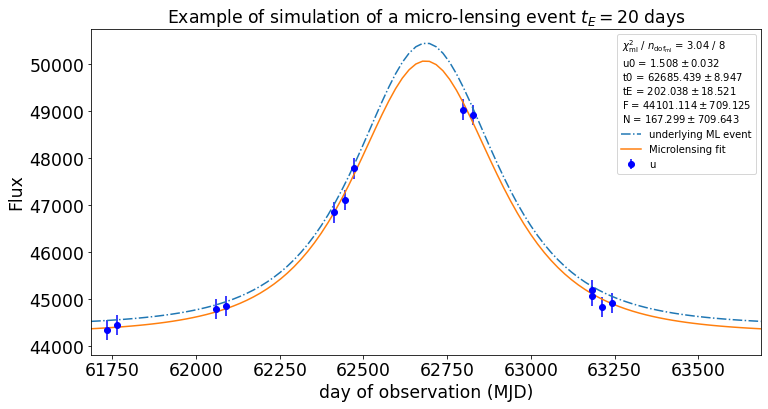

In [56]:
#Randomize parameters

from random import *

u0 = umin[randrange(len(umin))]
t0 = list_t0[randrange(len(list_t0))] 

#tE distribution or value

tE = 200

#Time t 

tmin = t0 - 5. * tE
tmax = t0 + 5. * tE
ti = np.linspace(tmin,tmax,100)


print("t0 = {}".format(t0)) #Display values
print("tE = {}".format(tE))
print("u0 = {}".format(u0))
print("A(t0) = {}".format(A(u(t0))))


#We distinguish data points by filter

df_event_u = df[(df["filter"] == "u") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
df_event_g = df[(df["filter"] == "g") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
df_event_r = df[(df["filter"] == "r") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
df_event_i = df[(df["filter"] == "i") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]  
df_event_z = df[(df["filter"] == "z") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]  
df_event_y = df[(df["filter"] == "y") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
df_event = df[(df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 

df_event_times = df_event["observationStartMJD"].values
df_event_times_u = df_event_u["observationStartMJD"].values 
df_event_times_g = df_event_g["observationStartMJD"].values
df_event_times_r = df_event_r["observationStartMJD"].values
df_event_times_i = df_event_i["observationStartMJD"].values
df_event_times_z = df_event_z["observationStartMJD"].values
df_event_times_y = df_event_y["observationStartMJD"].values


#Photometric Error


    
error = [[] for i in range (nbr_filters)]
y_data = [[] for i in range (nbr_filters)]
N_pe = [[] for i in range (nbr_filters)]
F_pe = [[] for i in range (nbr_filters)]
S_pe = [[] for i in range (nbr_filters)]

for i in range (len(df)) :
    
    
    if (df["filter"][i] == "u") & (df["observationStartMJD"][i] >= tmin) & (df["observationStartMJD"][i] <= tmax) & ((df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
    
        F_pe[1].append(all_count[0][i] * A(u(df["observationStartMJD"].values[i])))
        N_pe[1].append(N[0][i])   
        
    
    if (df["filter"][i] == "g") & (df["observationStartMJD"][i] >= tmin) & (df["observationStartMJD"][i] <= tmax) & ((df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :   
        
        F_pe[2].append(all_count[0][i] * A(u(df["observationStartMJD"].values[i])))
        N_pe[2].append(N[0][i])
        
    
    
    if (df["filter"][i] == "r") & (df["observationStartMJD"][i] >= tmin) & (df["observationStartMJD"][i] <= tmax) & ((df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :    
    
        F_pe[3].append(all_count[0][i] * A(u(df["observationStartMJD"].values[i])))
        N_pe[3].append(N[0][i])   
        

    
    if (df["filter"][i] == "i") & (df["observationStartMJD"][i] >= tmin) & (df["observationStartMJD"][i] <= tmax) & ((df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
        F_pe[4].append(all_count[0][i] * A(u(df["observationStartMJD"].values[i])))
        N_pe[4].append(N[0][i])   
       

    
    if (df["filter"][i] == "z") & (df["observationStartMJD"][i] >= tmin) & (df["observationStartMJD"][i] <= tmax) & ((df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
    
        F_pe[5].append(all_count[0][i] * A(u(df["observationStartMJD"].values[i])))
        N_pe[5].append(N[0][i])   
        
                  
    
    if (df["filter"][i] == "y") & (df["observationStartMJD"][i] >= tmin) & (df["observationStartMJD"][i] <= tmax) & ((df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
        F_pe[6].append(all_count[0][i] * A(u(df["observationStartMJD"].values[i])))
        N_pe[6].append(N[0][i])            
        

for i in range (len(F_pe[1])) :
    
    S_pe[1].append(F_pe[1][i] + N_pe[1][i])
    error[1].append(np.sqrt(S_pe[1][i]))
    
for i in range (len(F_pe[2])) :
    
    S_pe[2].append(F_pe[2][i] + N_pe[2][i])
    error[2].append(np.sqrt(S_pe[2][i]))
    
for i in range (len(F_pe[3])) :
    
    S_pe[3].append(F_pe[3][i] + N_pe[3][i])
    error[3].append(np.sqrt(S_pe[3][i]))
    
for i in range (len(F_pe[4])) :
    
    S_pe[4].append(F_pe[4][i] + N_pe[4][i])
    error[4].append(np.sqrt(S_pe[4][i]))
    
for i in range (len(F_pe[5])) :
    
    S_pe[5].append(F_pe[5][i] + N_pe[5][i])
    error[5].append(np.sqrt(S_pe[5][i]))
    
for i in range (len(F_pe[6])) :
    
    S_pe[6].append(F_pe[6][i] + N_pe[6][i])
    error[6].append(np.sqrt(S_pe[6][i]))
        
        
        
#Underlying ML event

plt.plot(ti, A(u(ti)) * F_0[1] + sum(N_pe[1])/len(N_pe[1]),"-.",label="underlying ML event")


# Microlensing fit with iMinuit

x = df_event_times       
x_u = df_event_times_u
x_g = df_event_times_g
x_r = df_event_times_r
x_i = df_event_times_i
x_z = df_event_times_z
x_y = df_event_times_y



#y = y_data[0] + error[0] * np.random.randn(len(x))

y_u = S_pe[1] 
y_g = S_pe[2]
y_r = S_pe[3] 
y_i = S_pe[4]
y_z = S_pe[5] 
y_y = S_pe[6]


plt.errorbar(x_u, y_u, error[1], fmt = "o", label = "u", color = "b")  #Show data points with their respective photometric error
#plt.errorbar(x_g, y_g, error[2], fmt = "o", label = "g", color = "g")  #Color depends on the filter
#plt.errorbar(x_r, y_r, error[3], fmt="o", label = "r", color = "r")
#plt.errorbar(x_i, y_i, error[4], fmt = "o", label = "i", color = "blueviolet")
#plt.errorbar(x_z, y_z, error[5], fmt = "o", label = "z", color = "grey")
#plt.errorbar(x_y, y_y, error[6], fmt = "o", label = "y", color = "k")

    
least_squares = LeastSquares(x_u, y_u, error[1], Model)        # Fit using the least squares method
m = Minuit(least_squares, u0 = u0, t0 = t0, tE = tE, F = F_0[1], N = sum(N_pe[1])/len(N_pe[1]))  #starting values for our parameters


m.migrad() # finds minimum of least_squares function
m.hesse()  # accurately computes uncertainties

plt.plot(ti, Model(ti, *m.values), label = "Microlensing fit") 


#Plot legend etc

fit_info = [
    f"$\\chi^2_\\mathrm{{ml}}$ / $n_\\mathrm{{dof_\\mathrm{{ml}}}}$ = {m.fval:.2f} / {len(x_u) - m.nfit}",    #Display fit info  
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.xlabel("day of observation (MJD)")
plt.ylabel("Flux")
plt.title("Example of simulation of a micro-lensing event $t_E = 20$ days")
plt.legend(title = "\n".join(fit_info))
plt.xlim(tmin,tmax)

In [41]:
F_pe[1]

[234608.53435670625,
 234019.3178236233,
 248211.66146124995,
 221319.46412631098,
 211449.06597100012,
 239037.66963728194,
 234482.12337048867,
 241550.63689514177,
 224314.03523615573,
 207495.36470349302,
 165556.9547275578,
 163215.8196038992,
 154501.80444058927,
 153161.7706581823,
 139718.15857016685,
 131868.03819973368]

In [42]:
error[1]

[484.6215161833281,
 484.00807281760945,
 498.4418295193332,
 470.6993863322892,
 460.10736547158825,
 489.1767606812047,
 484.4842131189783,
 491.7322813525971,
 473.8633304861073,
 455.81179193973804,
 407.1892967168656,
 404.33208208265995,
 393.3968025473679,
 391.6907664905599,
 374.10796694548515,
 363.4548897885287]

(61271.26473940619, 63271.26473940619)

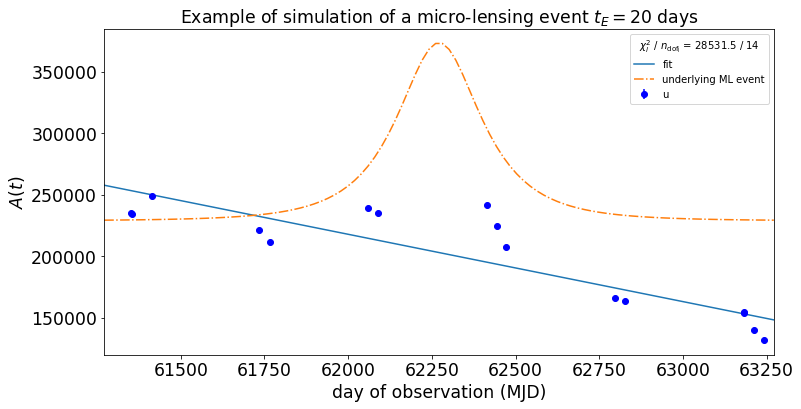

In [43]:
least_squares_line = LeastSquares(x_u, y_u, error[1], linear) #linear least squares
m_line = Minuit(least_squares_line, alpha=1, beta=1)  

m_line.migrad() # finds minimum of least_squares function
m_line.hesse()  # accurately computes uncertainties

plt.errorbar(x_u, y_u, error[1], fmt="o", label = "u", color = "b")  #Show data points with their respective photometric error
#plt.errorbar(x_g, y_g, error[2], fmt="o", label = "g", color = "g")  #Color depends on the filter
#plt.errorbar(x_r, y_r, amp_err_r, fmt="o", label = "r", color = "r")
#plt.errorbar(x_i, y_i, amp_err_i, fmt="o", label = "i", color = "blueviolet")
#plt.errorbar(x_z, y_z, amp_err_z, fmt="o", label = "z", color ="grey")
#plt.errorbar(x_y, y_y, amp_err_y, fmt="o", label = "y", color ="k")
plt.plot(ti, linear(ti, *m_line.values), label = "fit")
plt.plot(ti, A(u(ti)) * F_0[1] + sum(N_pe[1])/len(N_pe[1]), "-.", label = "underlying ML event")


fit_info = [
    f"$\\chi^2_l$ / $n_\\mathrm{{dof_l}}$ = {m_line.fval:.1f} / {len(x_u) - m_line.nfit}",     #Display fit info
]
plt.xlabel("day of observation (MJD)")
plt.ylabel("$A(t)$")
plt.title("Example of simulation of a micro-lensing event $t_E = 20$ days")
plt.legend(title = "\n".join(fit_info))
plt.xlim(tmin,tmax)

In [44]:
(m_line.fval - m.fval)/np.sqrt(2*(len(x_u)- m.nfit)) 

2948.7203968914373